<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Numerical Solution of the Scalar Wave Equation, in Cartesian Coordinates

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module solves the scalar wave equation in Cartesian coordinates, using the [Method of Lines](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

**Notebook Status:** <font color='green'><b>Validated</b></font>

**Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom).

### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) generates the right-hand side for the Scalar Wave Equation in Cartesian coordinates.
* [ScalarWave/InitialData.py](../edit/ScalarWave/InitialData.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) generates C code for plane wave or spherical Gaussian initial data for the scalar wave equation.

## Introduction:

As outlined in the [previous NRPy+ tutorial notebook](Tutorial-ScalarWave.ipynb), we first use NRPy+ to generate initial data for the scalar wave equation, and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step.

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration.
    * [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb)
1. Set gridfunction values to initial data .
    * [**NRPy+ tutorial notebook section on plane-wave solution to scalar wave equation**](Tutorial-ScalarWave.ipynb#planewave)
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm.
    1. At the start of each iteration in time, output the difference between the numerical and exact solution.
        * [**NRPy+ tutorial notebook section on plane-wave solution to scalar wave equation**](Tutorial-ScalarWave.ipynb#planewave)
    1. At each RK time substep, do the following.
        1. Evaluate scalar wave RHS expressions.
            * [**NRPy+ tutorial notebook section on right-hand sides of scalar wave equation, in 3 spatial dimensions**](Tutorial-ScalarWave.ipynb#rhss3d)
        1. Apply boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658).
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows.

1. [Step 1](#setup): Set up core functions and parameters for solving scalar wave equation
    1. [Step 1.a](#applybcs) `apply_bcs()`: outer boundary condition driver function
    1. [Step 1.b](#mol) Generate Method of Lines timestepping code
    1. [Step 1.c](#freeparams) Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 2](#mainc): `ScalarWave_Playground.c`: The Main C Code
1. [Step 3](#convergence): Code validation: Verify that relative error in numerical solution converges to zero at the expected order
1. [Step 4](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='setup'></a>

# Step 1: Set up core functions and parameters for solving scalar wave equation \[Back to [top](#toc)\]
$$\label{setup}$$

Let's pick up where we left off in the [previous module](Tutorial-ScalarWave.ipynb), interfacing with the [ScalarWave/InitialData](../edit/ScalarWave/InitialData.py) and [ScalarWave/ScalarWave_RHSs](../edit/ScalarWave/ScalarWave_RHSs.py) NRPy+ modules to generate
* monochromatic (single-wavelength) plane wave scalar wave initial data, and
* the scalar wave equation RHSs at **4th** finite difference order in **3 spatial dimensions**.

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh, add_to_Cfunction_dict  # NRPy+: Core C code output module
import finite_difference as fin       # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par        # NRPy+: Parameter interface
import grid as gri                    # NRPy+: Functions having to do with numerical grids
import cmdline_helper as cmd          # NRPy+: Multi-platform Python command-line interface
import shutil, os                     # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("ScalarWave_Ccodes")
# First remove C code output directory if it exists
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesrootdir, "output")
cmd.mkdir(outdir)

# Step P4: Set domain_size, the physical extent of numerical grid;
#          in Cartesian coordinates xmin=ymin=zmin=-domain_size,
#          and xmax=ymax=zmax=+domain_size
domain_size = 10.0

# Step P5: Set timestepping algorithm (we adopt the Method of Lines)
RK_method = "RK4"

# Step P6: Set the finite differencing order to 4.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 4)

# Step P7: Enable/disable SIMD. If enabled, code should run ~2x faster on most CPUs.
enable_SIMD = True

# Step 1: Import the ScalarWave.InitialData module.
#         This command only declares ScalarWave initial data
#         parameters and the InitialData() function.
import ScalarWave.InitialData as swid

# Step 2: Import ScalarWave_RHSs module.
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import ScalarWave.ScalarWave_RHSs as swrhs

# Step 3: The spatial dimension parameter defaults to 3;
#         no need to set!
# par.set_parval_from_str("grid::DIM", 3)

# Step 4: Call the InitialData() function to set up initial data.
#         Options include:
#    "PlaneWave": monochromatic (single frequency/wavelength) plane wave
#    "SphericalGaussian": spherically symmetric Gaussian, with default stdev=3
swid.InitialData(Type="PlaneWave")

# Step 5: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the ScalarWave RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
swrhs.ScalarWave_RHSs()

# Step 6: Enable "FD functions". In other words, all finite-difference stencils
#         will be output as inlined static functions. This is essential for
#         compiling highly complex FD kernels with using certain versions of GCC;
#         GCC 10-ish will choke on BSSN FD kernels at high FD order, sometimes
#         taking *hours* to compile. Unaffected GCC versions compile these kernels
#         in seconds. FD functions do not slow the code performance, but do add
#         another header file to the C source tree.
enable_FD_functions = True
par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# Step 7: If enable_SIMD, then copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
if enable_SIMD:
    shutil.copy(os.path.join("SIMD", "SIMD_intrinsics.h"), os.path.join(Ccodesrootdir, "SIMD"))

In [2]:
def add_to_Cfunction_dict_exact_solution_single_point():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Exact solution at a single point. params.time==0 corresponds to the initial data."
    c_type = "void"
    name = "exact_solution_single_point"
    params = """const paramstruct *restrict params,
                const REAL xx0, const REAL xx1, const REAL xx2,
                REAL *uu_exact, REAL *vv_exact"""
    body = fin.FD_outputC("returnstring",[lhrh(lhs="*uu_exact",rhs=swid.uu_ID),
                                          lhrh(lhs="*vv_exact",rhs=swid.vv_ID)],
                          params="includebraces=False,preindent=1,outCverbose=False")
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."))

In [3]:
def add_to_Cfunction_dict_exact_solution_all_points():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Exact solution at all points. params.time==0 corresponds to the initial data."
    c_type = "void"
    name = "exact_solution_all_points"
    params = "const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs"
    body = """exact_solution_single_point(params, xx0, xx1, xx2,
           &in_gfs[IDX4S(UUGF,i0,i1,i2)], &in_gfs[IDX4S(VVGF,i0,i1,i2)]);"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = "AllPoints,Read_xxs")

In [4]:
def add_to_Cfunction_dict_rhs_eval():
    desc="Evaluate the scalar wave RHSs"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    if enable_FD_functions:
        includes += ["finite_difference_functions.h"]
    if enable_SIMD:
        includes += ["SIMD/SIMD_intrinsics.h"]
    c_type = "void"
    name = "rhs_eval"
    params = "const paramstruct *restrict params, const REAL *restrict in_gfs, REAL *restrict rhs_gfs"
    body = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=swrhs.uu_rhs),
                                          lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=swrhs.vv_rhs)],
                          params="enable_SIMD="+str(enable_SIMD))
    loopopts = "InteriorPoints"
    if enable_SIMD:
        loopopts += ",enable_SIMD"
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)

In [5]:
def add_to_Cfunction_dict_diagnostic_output_2D_xy_plane():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc="As a diagnostic, output to file 2D data closest to the xy plane (z approx 0 plane)."
    c_type = "void"
    name = "diagnostic_output_2D_xy_plane"
    params = """const paramstruct *restrict params, const int iter, REAL *xx[3],
               const REAL *numerical_gridfunction_data,REAL *gridfunction_to_store_exact"""
    body = r"""  char filename[100];
  sprintf(filename, "output/out2D__resolution_%dx%dx%d__iter_%d.txt", Nxx0,Nxx1,Nxx2,iter);
  FILE *out2D = fopen(filename, "w");
  // Output on z=midpoint plane (points closest to z=0):
  const int i2  = (int)((Nxx2+ 2*NGHOSTS)*0.5);
  const REAL xx2 = xx[2][i2];
  for(int i0=0;i0<Nxx0+2*NGHOSTS;i0++) {
    for(int i1=0;i1<Nxx1+2*NGHOSTS;i1++) {
      // Zoom in; do not output data near outer boundary.
      if(i0> (Nxx0+2*NGHOSTS)*.25 && i0< (Nxx0+2*NGHOSTS)*.75 &&
         i1> (Nxx1+2*NGHOSTS)*.25 && i1< (Nxx1+2*NGHOSTS)*.75) {
        const REAL xx0 = xx[0][i0];
        const REAL xx1 = xx[1][i1];
        REAL uu_exact,vv_exact; exact_solution_single_point(params,xx0,xx1,xx2, &uu_exact,&vv_exact);
        fprintf(out2D,"%e %e %e %e\n", xx0, xx1,
                numerical_gridfunction_data[IDX4S(0,i0,i1, (int)((Nxx2+ 2*NGHOSTS)*0.5))], uu_exact);
      }
    }
  }
  fclose(out2D);
"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."))

<a id='applybcs'></a>

## Step 1.a: `apply_bcs()`: outer boundary condition driver function \[Back to [top](#toc)\]
$$\label{applybcs}$$

When solving the wave equation on a 3D Cartesian numerical grid cube (or, if you like, rectangular prism), at each step in time, we first evaluate the right-hand sides (RHSs) of the $\partial_t u$ and $\partial_t v$ equations. 

These RHSs generally contain spatial derivatives, which we evaluate using finite-difference differentiation ([**tutorial**](Tutorial-Finite_Difference_Derivatives.ipynb)). Each finite-difference derivative depends on neighboring points on the left and right, so the RHSs can only be evaluated in the grid interior. For example, a standard fourth-order centered finite difference derivative depends on two points to the left and right of the point at which the derivative is being evaluated. In order for the same interior to be filled at the next time step, we need to fill in the data at the boundaries; i.e., we need to apply boundary conditions.

Here we quadratically extrapolate data to the outer boundary using the `FACE_UPDATE()` C macro defined below. The C code function `apply_bcs()` below updates all 6 faces of the cube. To ensure that all gridpoints on the outer boundary (also known as "ghost cells") are filled, the following algorithm is implemented, starting at the innermost ghost cells (i.e., the ghost cells closest to the grid interior):

1. The lower $x$ face is updated on only the interior points of the face.
1. The upper $x$ face is updated on only the interior points of the face.
1. The lower $y$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points.
1. The upper $y$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points.
1. The lower $z$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points, plus the lower and upper $y$ boundary points.
1. The upper $z$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points, plus the lower and upper $y$ boundary points.
1. The above is repeated on the next outer ghost cell, until all outer boundary points are filled.

In [6]:
def add_to_Cfunction_dict_apply_bcs():
    desc="""Apply (quadratic extrapolation) spatial boundary conditions to the scalar wave gridfunctions.
BCs are applied to all six boundary faces of the cube, filling in the innermost
ghost zone first, and moving outward."""
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    c_type = "void"
    name = "apply_bcs"
    params = "const paramstruct *restrict params,REAL *restrict gfs"
    prefunc = r"""
// Declare boundary condition FACE_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;
#define  FACE_UPDATE(which_gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) { \
        gfs[IDX4S(which_gf,i0,i1,i2)] =                                  \
          +3.0*gfs[IDX4S(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]  \
          -3.0*gfs[IDX4S(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]  \
          +1.0*gfs[IDX4S(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)]; \
      }
"""
    body = r"""
#pragma omp parallel for
    for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) {
#include "set_Cparameters.h"
      int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
      int imax[3] = { Nxx_plus_2NGHOSTS0-NGHOSTS, Nxx_plus_2NGHOSTS1-NGHOSTS, Nxx_plus_2NGHOSTS2-NGHOSTS };
      for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
        // After updating each face, adjust imin[] and imax[]
        //   to reflect the newly-updated face extents.
        FACE_UPDATE(which_gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
        FACE_UPDATE(which_gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

        FACE_UPDATE(which_gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
        FACE_UPDATE(which_gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

        FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
        FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
    }
  }
"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        prefunc=prefunc, body=body,
        rel_path_to_Cparams=os.path.join("."))

<a id='mol'></a>

## Step 1.b: Generate Method of Lines timestepping code \[Back to [top](#toc)\]
$$\label{mol}$$

The Method of Lines algorithm is described in detail in the [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

In [7]:
# Step 1.b: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 2-step process:
#       1.b.A: Evaluate RHSs (RHS_string)
#       1.b.B: Apply boundary conditions (post_RHS_string, pt 1)
import MoLtimestepping.MoL as MoL
# from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
# RK_order  = Butcher_dict[RK_method][1]
# cmd.mkdir(os.path.join(Ccodesrootdir,"MoLtimestepping/"))
MoL.register_C_functions_and_NRPy_basic_defines(RK_method,
    RHS_string      =  "rhs_eval(params,   RK_INPUT_GFS, RK_OUTPUT_GFS);",
    post_RHS_string = "apply_bcs(params,  RK_OUTPUT_GFS);", enable_SIMD=enable_SIMD)

<a id='freeparams'></a>

## Step 1.c: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{freeparams}$$

Here we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above.

In [8]:
domain_size_str=str(domain_size)
# Step 3.d: Set free_parameters.h
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(r"""
// Set free-parameter values.

// Set free-parameter values for the initial data.
params.time = 0.0; params.wavespeed = 1.0;
//params.kk0 = 1.0; params.kk1 = 1.0; params.kk2 = 1.0;

const REAL domain_size    = """+str(domain_size)+r""";

// Override parameter defaults with values based on command line arguments and NGHOSTS.
const int Nx0x1x2 = atoi(argv[1]);
params.Nxx0 = Nx0x1x2;
params.Nxx1 = Nx0x1x2;
params.Nxx2 = Nx0x1x2;
params.Nxx_plus_2NGHOSTS0 = params.Nxx0 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS1 = params.Nxx1 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS2 = params.Nxx2 + 2*NGHOSTS;
// Step 0d: Set up space and time coordinates
// Step 0d.i: Declare \Delta x^i=dxx{0,1,2} and invdxx{0,1,2}, as well as xxmin[3] and xxmax[3]:
const REAL xxmin[3] = {-"""+domain_size_str+""",-"""+domain_size_str+""",-"""+domain_size_str+""" };
const REAL xxmax[3] = {+"""+domain_size_str+""",+"""+domain_size_str+""",+"""+domain_size_str+r""" };

params.dxx0 = (xxmax[0] - xxmin[0]) / ((REAL)params.Nxx0);
params.dxx1 = (xxmax[1] - xxmin[1]) / ((REAL)params.Nxx1);
params.dxx2 = (xxmax[2] - xxmin[2]) / ((REAL)params.Nxx2);
params.invdx0 = 1.0 / params.dxx0;
params.invdx1 = 1.0 / params.dxx1;
params.invdx2 = 1.0 / params.dxx2;
""")

<a id='mainc'></a>

# Step 2: `ScalarWave_Playground`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

Next we will write the C code infrastructure necessary to make use of the above NRPy+-generated codes. Again, we'll be using RK4 time integration via the Method of Lines.

In [9]:
def add_to_Cfunction_dict_main__ScalarWave_Playground():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    prefunc = """
// Frequency of output.
const int NSKIP_0D_OUTPUT = 1;
const int NSKIP_2D_OUTPUT = 10;
"""
    desc = """
// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""
  paramstruct params;
  set_Cparameters_to_default(&params);

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 2 || atoi(argv[1]) < NGHOSTS) {
    printf("Error: Expected one command-line argument: ./ScalarWave_Playground [Nx(=Ny=Nz)],\n");
    printf("where Nx is the number of grid points in the x,y, and z directions.\n");
    printf("Nx MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  if(atoi(argv[1])%2 != 0) {
    printf("Error: Algorithm for setting up cell-centered grids here requires Nx, Ny, and Nz to be a multiple of 2 .\n");
    exit(1);
  }

  // Step 0b: Set free parameters, overwriting Cparameters defaults
  //          by hand or with command-line input, as desired.
#include "free_parameters.h"
  //          ... and then set up the numerical grid structure in time:
  const REAL CFL_FACTOR = 0.5; // Set the CFL Factor
  #define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
  const REAL dt = CFL_FACTOR * MIN(params.dxx0,MIN(params.dxx1,params.dxx2)); // CFL condition

  // Step 0c: Now that params struct has been properly set up, create
  //   list of const's containing each parameter. E.g.,
  //  const REAL dxx0 = params.dxx0;
#include "set_Cparameters-nopointer.h"

  // Step 0d: Declare struct for gridfunctions and allocate memory for gridfunctions
  MoL_gridfunctions_struct gridfuncs;
  MoL_malloc_y_n_gfs(&params, &gridfuncs);
  MoL_malloc_non_y_n_gfs(&params, &gridfuncs);

  // Step 0e: Set t_final, and number of timesteps based on t_final
  const REAL t_final = xxmax[0]*0.8; /* Final time is set so that at t=t_final,
                                  data at the origin have not been corrupted
                                  by the approximate outer boundary condition */
  int Nt = (int)(t_final / dt + 0.5); // The number of points in time.
                                      //Add 0.5 to account for C rounding down integers.

  // Step 0f: Set up cell-centered Cartesian coordinate grids
  REAL *xx[3];
  xx[0] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS0);
  xx[1] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS1);
  xx[2] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS2);
  for(int j=0;j<Nxx_plus_2NGHOSTS0;j++) xx[0][j] = xxmin[0] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*params.dxx0;
  for(int j=0;j<Nxx_plus_2NGHOSTS1;j++) xx[1][j] = xxmin[1] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*params.dxx1;
  for(int j=0;j<Nxx_plus_2NGHOSTS2;j++) xx[2][j] = xxmin[2] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*params.dxx2;

  // Step 1: Set up initial data to be exact solution at time=0:
  params.time = 0.0; exact_solution_all_points(&params, xx, gridfuncs.y_n_gfs);

  for(int n=0;n<=Nt;n++) { // Main loop to progress forward in time.
    // Step 1a: Set current time to correct value & compute exact solution
    params.time = ((REAL)n)*dt;

    /* Step 2: Validation: Output relative error between numerical and exact solution, */
    // Step 2b: Output to 2D grid (region of x-y plane near origin)
    //          every NSKIP_2D_OUTPUT iterations.
    if((n)%NSKIP_2D_OUTPUT ==0) {
      // Step 2a: Output data on gridpoints closest to xy-plane, ignoring points "too close" to outer boundary
      diagnostic_output_2D_xy_plane(&params, n, xx, gridfuncs.y_n_gfs, gridfuncs.diagnostic_output_gfs);
    }

    if((n)%NSKIP_0D_OUTPUT ==0) {
      // Step 2c: Output relative error between exact & numerical at center of grid.
      const int i0mid=Nxx_plus_2NGHOSTS0/2;
      const int i1mid=Nxx_plus_2NGHOSTS1/2;
      const int i2mid=Nxx_plus_2NGHOSTS2/2;
      REAL uu_exact,vv_exact; exact_solution_single_point(&params, xx[0][i0mid],xx[1][i1mid],xx[2][i2mid],
                                                          &uu_exact,&vv_exact);

      const REAL numerical = gridfuncs.y_n_gfs[IDX4S(UUGF,i0mid,i1mid,i2mid)];
      const REAL relative_error = fabs((uu_exact-numerical)/uu_exact) + 1e-16; // Add 1e-16 in case relerror
                                                                               // is exactly zero.
      printf("%e %e || %e %e %e: %e %e\n",params.time, log10(relative_error),
             xx[0][i0mid],xx[1][i1mid],xx[2][i2mid], numerical,uu_exact);
    }

    // Step 3: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
    //         applying quadratic extrapolation outer boundary conditions.
    // Step 3.b: Step forward one timestep (t -> t+dt) in time using
    //           chosen RK-like MoL timestepping algorithm
    MoL_step_forward_in_time(&params, xx, &gridfuncs, dt);
  } // End main loop to progress forward in time.

  // Step 4: Free all allocated memory
  MoL_free_memory_y_n_gfs(&params, &gridfuncs);
  MoL_free_memory_non_y_n_gfs(&params, &gridfuncs);
  for(int i=0;i<3;i++) free(xx[i]);
  return 0;
"""
    add_to_Cfunction_dict(
        includes=includes, prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

In [10]:
def register_C_code_functions_scalarwave():
    add_to_Cfunction_dict_exact_solution_single_point()
    add_to_Cfunction_dict_exact_solution_all_points()
    add_to_Cfunction_dict_rhs_eval()
    add_to_Cfunction_dict_diagnostic_output_2D_xy_plane()
    add_to_Cfunction_dict_apply_bcs()
    add_to_Cfunction_dict_main__ScalarWave_Playground()

import outputC as outC
outC.outputC_register_C_functions_and_NRPy_basic_defines()  # #define M_PI,  etc.
# Declare paramstruct, register set_Cparameters_to_default(),
#   and output declare_Cparameters_struct.h and set_Cparameters[].h:
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))

gri.register_C_functions_and_NRPy_basic_defines(enable_griddata_struct=False)  # #define IDX3S(),  etc.
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=False)  # #define NGHOSTS, etc.

# all functions needed for scalar wave:
register_C_code_functions_scalarwave()

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesrootdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=enable_SIMD)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

In [11]:
import cmdline_helper as cmd
cmd.new_C_compile(Ccodesrootdir, "ScalarWave_Playground",
                  uses_free_parameters_h=True, compiler_opt_option="fast") # fastdebug or debug also supported
os.chdir(Ccodesrootdir)
for res in ["48", "64", "96"]:
    cmd.Execute("ScalarWave_Playground", res, os.path.join("output", "out"+res+".txt"))
os.chdir("..")
# import sys
# sys.exit(1)

(EXEC): Executing `make -j18`...
(BENCH): Finished executing in 1.01 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./ScalarWave_Playground 48`...
(BENCH): Finished executing in 0.20 seconds.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./ScalarWave_Playground 64`...
(BENCH): Finished executing in 0.40 seconds.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./ScalarWave_Playground 96`...
(BENCH): Finished executing in 1.61 seconds.


<a id='convergence'></a>

# Step 3: Code Validation: Verify that relative error in numerical solution converges to zero at the expected order \[Back to [top](#toc)\]
$$\label{convergence}$$

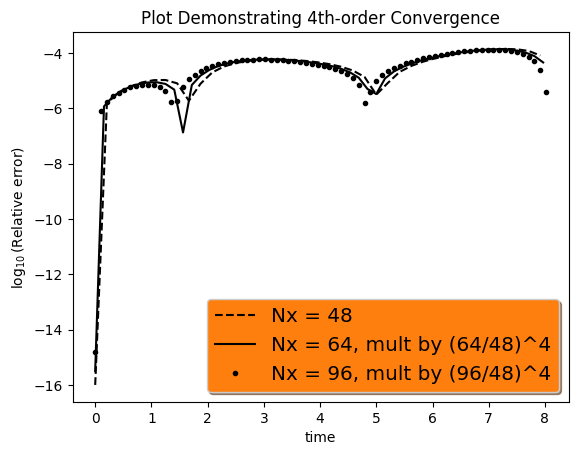

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1

first_col48,second_col48 = file_reader(os.path.join(outdir,"out48.txt"))
first_col64,second_col64 = file_reader(os.path.join(outdir,"out64.txt"))
first_col96,second_col96 = file_reader(os.path.join(outdir,"out96.txt"))

for i in range(len(second_col64)):
    # data64 = data48*(64/48)**4
    # -> log10(data64) = log10(data48) + 4*log(64/48)
    second_col64[i] += 4*mp.log10(64./48.)
for i in range(len(second_col96)):
    # data96 = data48*(96/48)**4
    # -> log10(data96) = log10(data48) + 4*log(96/48)
    second_col96[i] += 4*mp.log10(96./48.)

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py
fig, ax = plt.subplots()

plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("time")
plt.ylabel(r"$\log_{10}$(Relative error)")

ax.plot(first_col48, second_col48, 'k--', label='Nx = 48')
ax.plot(first_col64, second_col64, 'k-', label='Nx = 64, mult by (64/48)^4')
ax.plot(first_col96, second_col96, 'k.', label='Nx = 96, mult by (96/48)^4')

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 4: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWave.pdf](Tutorial-Start_to_Finish-ScalarWave.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [13]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-ScalarWave")

Created Tutorial-Start_to_Finish-ScalarWave.tex, and compiled LaTeX file to
    PDF file Tutorial-Start_to_Finish-ScalarWave.pdf
